#FINAL Functional MRI
## Romy BEAUTÉ
### MVA 2021/2022

file:///Users/romybeaute/Downloads/td/_build/html/td12.html


# Question 1
1.1 **Run the plot_haxby_anova_svm.py example of Nilearn.**

1.2 **Change the target y to test the cat class against face**.   

1.3 **Compute the standard deviation of accuracy across folds**.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") #silence warnings

try:
  import nilearn
except:
  !pip install nilearn

# Decoding with ANOVA + SVM: face vs house in the Haxby dataset

This example does a simple but efficient decoding on the Haxby dataset:
using a feature selection, followed by an SVM.


# PART 0 : Preparing Haxby dataset



## 0.1 Loading & describing Haxby Dataset

fMRI dataset from a **study on face and object representation in human ventral temporal cortex**. \\
Design overview : 
- 6 subjects with 12 runs (sessions) per subject
- for each run, subjects passively viewed greyscale images of **8 object categories**, grouped in 24s blocks separated by rest periods. 
- Each image shown for 500ms and followed by a 1500ms inter-stimulus interval
- Full-brain fMRI data recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes. 

Ressources : http://dev.pymvpa.org/datadb/haxby2001.html

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame

from nilearn import plotting
from nilearn.image import index_img,mean_img #useful for later, when creating labels for different conditions and images
from nilearn import datasets


def load_haxby():

  print('Loading Haxby dataset...\n')
  # By default 2nd subject will be fetched
  haxby_dataset = datasets.fetch_haxby() #Load the subject N°2
  print(haxby_dataset.keys()) #print content dataset


  #Load behavioral dataset
  print(70*'-')
  print('\nLoading BEHAVIORAL data')
  behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ") #behavioral dataset of the Haxby
  object_categories = np.unique(behavioral['labels'])  # different categories that are present in the dataset 
  print('List of labels for object categories (n = {} category labels ) : \n{}\n'.format(len(object_categories)-1,[obj for obj in object_categories if obj !='rest']))



  #Load fMRI data :
  print(70*'-')
  print('\nLoading fMRI data')
  fmri_img = haxby_dataset.func[0] #Paths to nifti file with bold data.

  # print basic information on the fMRI dataset :
  print('\n - Loaded subject n°{} from Haxby dataset'.format(datasets.fetch_haxby().func[0].split('/')[4]))
  print(' - Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
  print(' - Functional nifti image (4D) is located at: %s\n' %fmri_img)

  return haxby_dataset,fmri_img,behavioral

## 0.2 Loading the data & Visualising fMRI volume

Here have to make use of mean-img to plot data in 4D (i.e combinaison of several 3D EPI images), in order to extract a single (averaged) 3D EPI image from the data : 

Loading Haxby dataset...

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description'])
----------------------------------------------------------------------

Loading BEHAVIORAL data
List of labels for object categories (n = 8 category labels ) : 
['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix', 'shoe']

----------------------------------------------------------------------

Loading fMRI data

 - Loaded subject n°subj2 from Haxby dataset
 - Mask nifti image (3D) is located at: /root/nilearn_data/haxby2001/mask.nii.gz
 - Functional nifti image (4D) is located at: /root/nilearn_data/haxby2001/subj2/bold.nii.gz




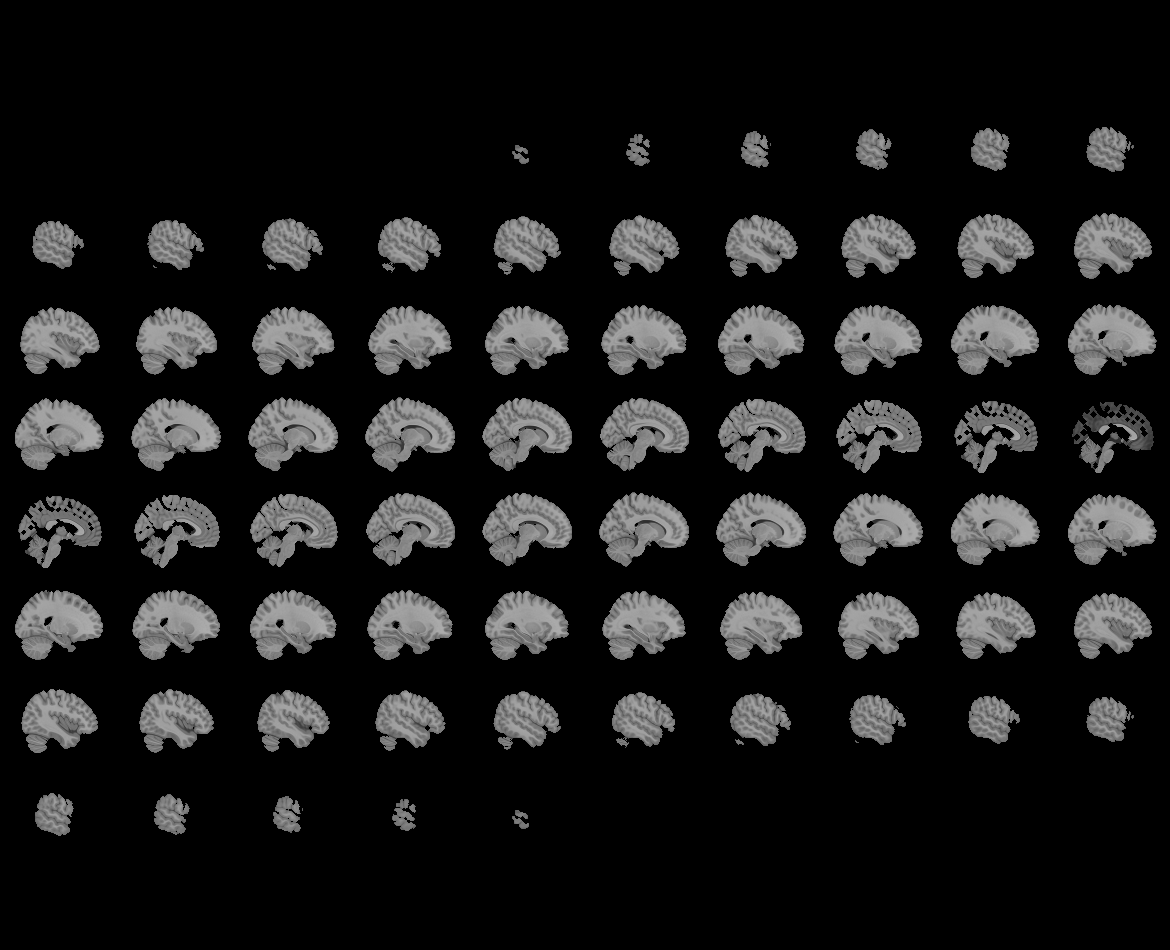
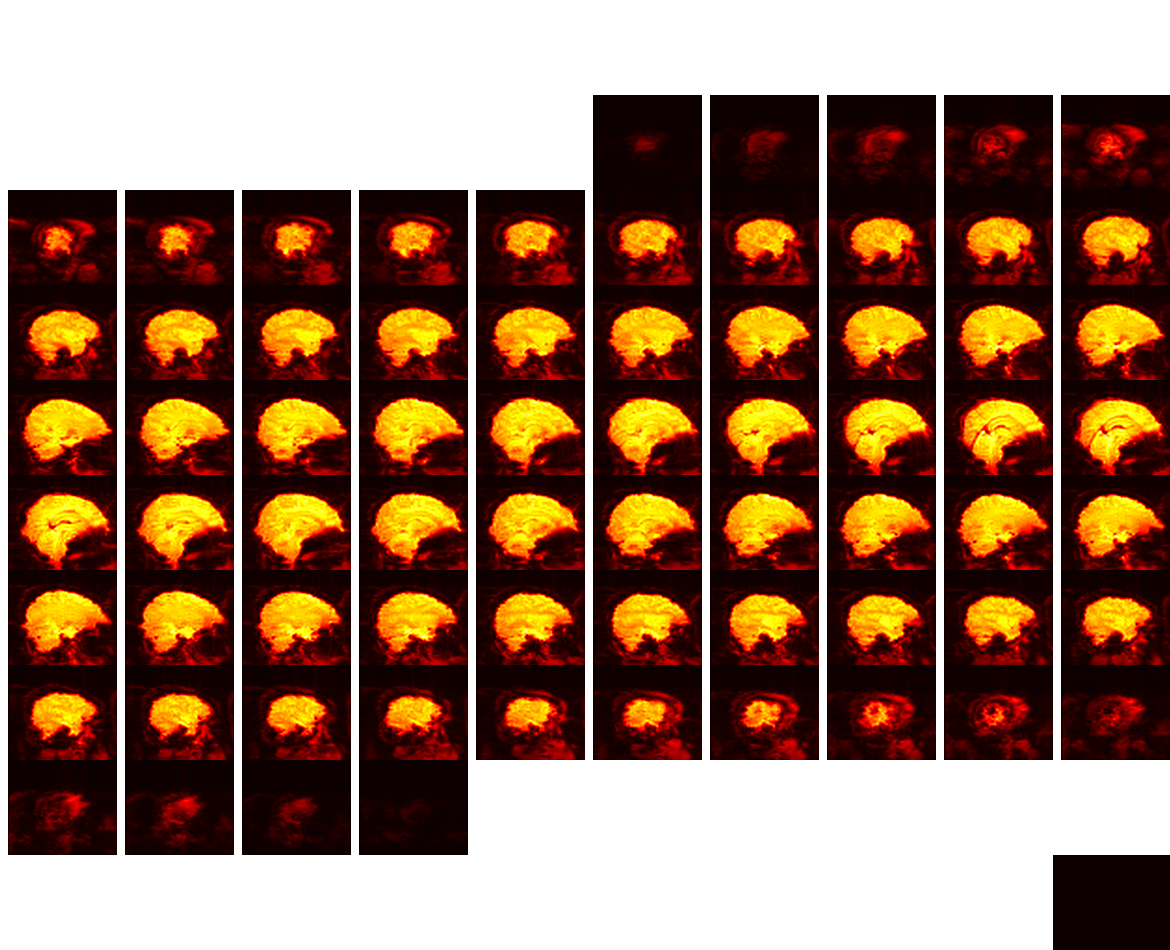

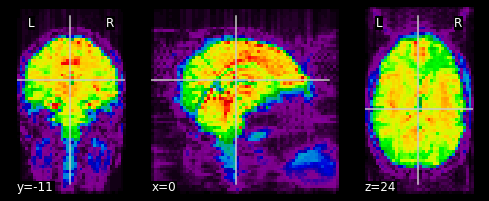

In [3]:
from nilearn.image import mean_img
from nilearn.plotting import plot_epi

haxby_dataset,fmri_img,behavioral = load_haxby()

plot_epi(mean_img(fmri_img)) #moyenne temporale de la série d'image (on l'applatit, car trop dur de regarder en 3D)
plotting.view_img(mean_img(fmri_img), threshold=None) #visualisation of fetched fmri data from Haxby dataset

#PART I
# Question 1.1 : Restrict the analysis to **cat against face**

Analysis resticted to following conditions : ['face' 'cat']
Reshaping input data after mask : (1452,) --> (216,)


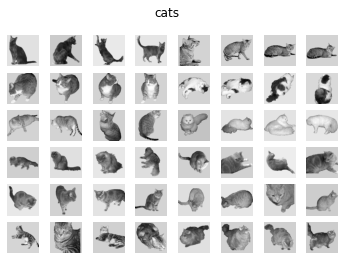

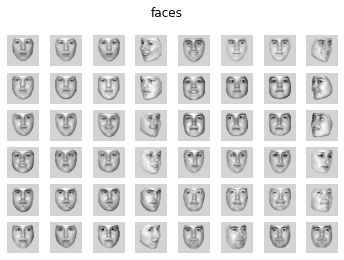

In [4]:
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.plotting import show

conditions = behavioral['labels'] #experimental conditions --> will be used to define the ones we want to keep for our analysis
condition_one = 'face'
condition_two = 'cat'
condition_mask = conditions.isin([condition_one, condition_two]) 


def condition_selection(conditions,condition_one,condition_two,show_stim=True):
  """
  Restrict the analysis to conditions of interest (specified by condition_one and condition_two respectively)
  Apply mask on both targets (behavioral labels) and input data (fMRI signal)
  In this work, we restrict the analysis to cat against face : 
  - condition_one (='face') 
  - condition_two (='cats')
  """
  

  #Reduction of input data
  condition_mask = conditions.isin([condition_one, condition_two]) 
  conditions = conditions[condition_mask]
  

  #Reduce fMRI input data (using only signals corresponding to conditions of interest)
  fmri_img_mask = index_img(fmri_img, condition_mask) #index_img enable to do the split easily, as that data is in one single large 4D image

  # Confirm that we now have 2 conditions
  print('Analysis resticted to following conditions : {}'.format(conditions.unique()))
  print('Reshaping input data after mask : {} --> {}'.format(behavioral['labels'].shape,conditions.shape)) #sanitary check

  # The number of the session is stored in the CSV file giving the behavioral data. We have to apply our session mask, to select only faces and houses : 
  session_label = behavioral['chunks'][condition_mask]

  if show_stim:

    restr_conditions = ['cats','faces']

    haxby_dataset = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
    stimulus_information = haxby_dataset.stimuli

    for stim_type in stimulus_information:
      if restr_conditions.count(stim_type):
        if stim_type != 'controls':

            file_names = stimulus_information[stim_type]

            fig, axes = plt.subplots(6, 8)
            fig.suptitle(stim_type)

            for img_path, ax in zip(file_names, axes.ravel()):
                ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

            for ax in axes.ravel():
                ax.axis("off")

    show()
  

  return session_label,conditions,fmri_img_mask


session_label, conditions, fmri_img = condition_selection(conditions,condition_one,condition_two,show_stim=True)

# Question 1.2 : Compute the standard deviation of accuracy across folds.

# Feature extraction
fMRI neuroimagin technique gives us images as data. However, we will need to convert our actual data - fMRI volumes (Nifti images) - into matrices to apply machine learning on it. This is why in this section, we will make use of the Decoder object, that will enable to automatically transform Nifti images into matrices.

Here we visualise the effect of two different mask, useful if need to change the mask in further steps.

Loading path to fullbrain mask file : 
 /root/nilearn_data/haxby2001/mask.nii.gz 



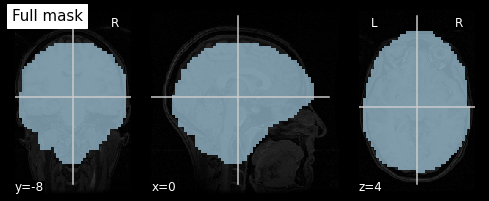

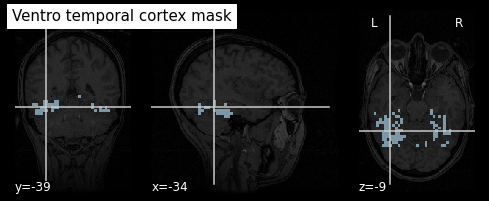

In [5]:
#Preparing and visualing the mask for dimension reduction and selection of areas/labels of interest (pre-processing)

# Here screening_percentile is set to 5 percent
mask_img = haxby_dataset.mask #define the mask filename
mask_img_vt = haxby_dataset.mask_vt #define a mask of the ventral temporal (VT) cortex (racall that study on face and object representation in human ventral temporal cortex)

print('Loading path to fullbrain mask file : \n {} \n'.format(mask_img))

# Visualisation of the full brain mask and VT mask
plotting.plot_roi(mask_img, 
                  bg_img=haxby_dataset.anat[0], #set subject's anatomical image as background
                  cmap='Paired',
                  title='Full mask')

plotting.plot_roi(mask_img_vt[0], 
                  bg_img=haxby_dataset.anat[0], #set subject's anatomical image as background
                  cmap='Paired',
                  title='Ventro temporal cortex mask')



#DECODING : prediction from brain images/signals

## ANOVA pipeline with :class:`nilearn.decoding.Decoder` object

Nilearn Decoder object aims to provide smooth user experience by acting as a
pipeline of several tasks: preprocessing with NiftiMasker, reducing dimension
by selecting only relevant features with ANOVA -- a classical univariate
feature selection based on F-test, and then decoding with different types of
estimators (in this example is Support Vector Machine with a linear kernel)
on nested cross-validation.



## Fit the decoder and predict



In [6]:
import time
from nilearn.decoding import Decoder

n_sessions = len(np.unique(session_label))
t0 = time.time()


'''
Creation/definition of the Decoder : object that can be fit (or trained) on data with labels, and then predict labels on data without labels
'''

decoder = Decoder(estimator='svc', #using Support Vector Classifier with a linear kernel
                  mask=mask_img, #using mask defined above
                  smoothing_fwhm=4,
                  standardize=True, 
                  screening_percentile=5, 
                  scoring='accuracy') #measure its performance by defining accuracy as the scoring parameter.

print(' Defined Decoder object : \n {}'.format(decoder))



decoder.fit(fmri_img, conditions) #fit the decoder on the fmri data (fmri_img) with labels (conditions)

y_pred = decoder.predict(fmri_img) #predict the conditions from fmri data

print(70*'-')
print('\nKeeping n={} stimuli after mask applied shape'.format(conditions.shape[0])) #quality check : verify that mask has been taken into account
print('\nDisplaying prediction labels for the 1st session (n = {} stimuli) : \n'.format(int(conditions.shape[0]/n_sessions)))
for i, (cond,pred) in enumerate(zip(conditions[:18],y_pred[:18])):
  print('Condition (label) : {} --> Predicted : {}'.format(cond,pred))

print('\nRun time : {:.2f} s'.format(time.time()-t0))

 Defined Decoder object : 
 Decoder(mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)
----------------------------------------------------------------------

Keeping n=216 stimuli after mask applied shape

Displaying prediction labels for the 1st session (n = 18 stimuli) : 

Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : face --> Predicted : face
Condition (label) : cat --> Predicted : cat
Condition (label) : cat --> Predicted : cat
Condition (label) : cat --> Predicted : cat
Condition (label) : cat --> Predicted : cat
Condition (label) : cat --> Predicted : cat
Condition (label) : c

Printing label's classification of the first session (n=18 events),we see that they all have been perfectly predicted. 
We therefore expect to obtain an accuracy of 1.0 when computing the averaged precision accuracy score across sessions. Let's calculate it : 

### Compute the accuracy of prediction to measure decoder performance in the classification task ('cat' vs 'face')

In [7]:
print('Averaged prediction accuracy score on {} conditions (n = {} stimuli): '.format(np.unique(conditions),conditions.shape[0]))

print((y_pred == conditions).sum() / float(len(conditions))) #prediction accuracy score

Averaged prediction accuracy score on ['cat' 'face'] conditions (n = 216 stimuli): 
1.0


This way of computing the accuracy of prediction seemed flawed, as we obtained an accuracy score of 1.0. Indeed, it is a methodological flaw to train the model to learn the parameters of a prediction function, and testing its prediction performance using the same data. In other words, a perfect score regarding prediction of seen data does not signifies that the model would do good with unseen data (overfitting). 
We will therefore use another way to measuring the prediction accuracy, using cross validation. This method will enable testing our model on "new" data, than hasn't been used to train the model. This will enable us to determine how the model perform in general (vs on familiar data).

In [8]:
def run_decoder(cv,group_by,n_group_out,print_folds=False):
  
  """
  Define decoder parameters to run the prediction accuracy for the different folds (i.e. session)
  """

  decoder = Decoder(estimator='svc', #use a Support Vector Classifier with a linear kernel
                  mask=mask_img, #using mask defined above
                  smoothing_fwhm=4,
                  standardize=True, #data centered (mean=0) and normed (variance=1)
                  screening_percentile=5, #percentage of brain volume that will be kept (with respect to a full MNI template). As <100, a univariate feature selection based on the Anova F-value for the input data will be performed
                  scoring='accuracy', #measure performance by defining accuracy as the scoring parameter.
                  cv=cv)
  
  print(' Defined Decoder object with folowing parameters : {}\n'.format(decoder))
  print('\n* Classification task : {} vs {}'.format(np.unique(conditions)[0],np.unique(conditions)[1]))
  print('* CV generator : {}'.format(decoder.cv)) #list of the n folds (corresponding to different session)
  try:
    print('* CV scheme : Leave-{}-session-out'.format(decoder.cv.n_groups))
  except:
    print('* CV scheme : Leave-{}-session-out'.format(n_group_out))



  decoder.fit(
      X=fmri_img, #Data on which model is to be fitted
      y=conditions, #Target variable to predict
      groups=group_by//n_group_out) #Group label for the samples used while splitting the dataset into (leave a session out scheme)


  print('* n folds = {}\n'.format(len(decoder.cv_))) #List of the (n_folds,) folds



  if print_folds: #detail accuracy accross each fold
    for indx, (score,test_out_fold) in enumerate(zip(
        decoder.cv_scores_[condition_one], #Scores (misclassification) for each parameter, and on each fold
        decoder.cv_)): #List of the (n_folds,) folds
      print(' - CV Fold {} : Prediction accuracy = {:.2f}'.format(indx,score))

      #List of the (n_folds,) folds. For the corresponding fold, each pair is composed of two lists of indices, one for the train samples and one for the test samples.
      print(' - Group out (test set) : {}\n (test size ={} --> {} sessions out)'.format(test_out_fold[1],len(test_out_fold[1]),len(test_out_fold[1])//18)) #print the group out for the test set 


  avg_score = decoder.cv_scores_[condition_one]


  print(70 * '_')


  print("Average prediction accuracy score : %1.2f +- %1.2f (std)" % (
      np.mean(avg_score),
      np.std(avg_score)
      ))
  print('Run time : {:.2f} s'.format(time.time()-t0))
  print(70 * '_')
  
  return decoder,avg_score

In [9]:
#question 1

from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut

cv = LeaveOneGroupOut() #split the data in train and test sets (data splitted according to a third-party)
group_by = session_label #define the group as session
n_group_out = 1 #allows to modify CV scheme : number of group outs


decoder,avg_score = run_decoder(cv,group_by,n_group_out,print_folds=True)


 Defined Decoder object with folowing parameters : Decoder(cv=LeaveOneGroupOut(), mask='/root/nilearn_data/haxby2001/mask.nii.gz',
        scoring='accuracy', screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : LeaveOneGroupOut()
* CV scheme : Leave-1-session-out
* n folds = 12

 - CV Fold 0 : Prediction accuracy = 0.94
 - Group out (test set) : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 (test size =18 --> 1 sessions out)
 - CV Fold 1 : Prediction accuracy = 1.00
 - Group out (test set) : [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
 (test size =18 --> 1 sessions out)
 - CV Fold 2 : Prediction accuracy = 1.00
 - Group out (test set) : [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
 (test size =18 --> 1 sessions out)
 - CV Fold 3 : Prediction accuracy = 0.67
 - Group out (test set) : [54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
 (test size =18 --> 1 sessions out)
 - CV Fold 4 : Prediction accuracy 

## Visualize the results
Look at the SVC's discriminating weights using
:class:`nilearn.plotting.plot_stat_map`



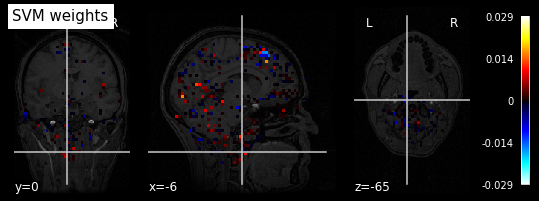

In [10]:
from nilearn.plotting import plot_stat_map, show, view_img

weight_img = decoder.coef_img_['face']

plot_stat_map(weight_img, bg_img=haxby_dataset.anat[0], title='SVM weights')

show()

Or we can plot the weights using :class:`nilearn.plotting.view_img` as a
dynamic html viewer



In [11]:
view_img(weight_img, bg_img=haxby_dataset.anat[0],
         title="SVM weights", dim=-1)

show()

#PART 2
# Question 2

The current cross-validation scheme is ‘leave-two-consecutive-session-out’. Change it to :
- ‘leave-one-session-out’
- ‘leave-three-consecutive-session-out’

What is the impact on the average score and on the variability across folds ?

In [12]:
leave_n_out = [1,2,3] #here we will test over 3 different scheme : leave-one-one,leave-two-out, leave-three-out --> var leave_n_out will redefine notion of group by merging n consequtive sessions together
dict_schemes = {}

## Obtain prediction scores via cross validation
Define the cross-validation scheme used for validation. Here we use a
LeaveOneGroupOut cross-validation on the session group which corresponds to a
leave a session out scheme, then pass the cross-validator object to the cv
parameter of decoder.leave-one-session-out For more details please take a
look at:
<https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#measuring-prediction-scores-using-cross-validation>



# PART 2 - METHOD 2.1 : LeaveOneGroupOut() and defining Metadata to add meta-group (grouping sessions)

Here, we first define a meta-group (merging 2 sessions) by hand, and store it in a "metadata" dataframe. The changing of scheme is therefore done here at the level of the data (redefine notion of group sessions).

In [13]:
from pandas import DataFrame


for scheme in leave_n_out:
  behavioral['chunk-{}-conseq-out'.format(scheme)] = behavioral['chunks']//scheme

session_label = behavioral['chunks'][condition_mask]
session_label_consq2 = behavioral['chunk-2-conseq-out'][condition_mask]
session_label_consq3 = behavioral['chunk-3-conseq-out'][condition_mask]

metadata = DataFrame(dict(
    session_label=session_label,
    session_label_consq2=session_label_consq2,
    session_label_consq3=session_label_consq3,
    face=conditions=='face',
    conditions=conditions))

metadata

,session_label,session_label_consq2,session_label_consq3,face,conditions
21,0,0,0,True,face
22,0,0,0,True,face
23,0,0,0,True,face
24,0,0,0,True,face
25,0,0,0,True,face
...,...,...,...,...,...
1427,11,5,3,False,cat
1428,11,5,3,False,cat
1429,11,5,3,False,cat
1430,11,5,3,False,cat


In [14]:
#Question 2 - Method 2.1

cv = LeaveOneGroupOut() #split the data in train and test sets (data splitted according to a third-party)
cv_schemes = ['session_label','session_label_consq2','session_label_consq3'] # define the third-party group as 'session_label' : N session consequtives
cv_schemes_csq = ['1_sess_out_csq','2_sess_out_csq','3_sess_out_csq'] #labels for n consequtive sessions out
cv_schemes_nocsq = ['1_sess_out','2_sess_out','3_sess_out'] #labels for n non consequtive sessions out
cv_scores = list()
std_scores = list()
scores = {}

#here redefine the notion of group : merging consequtive sessions :
n_group_out = 1 #1 group is now composed of n consequtive sessions sessions


for s in range(len(cv_schemes)):
  group_by = metadata[cv_schemes[s]]
  decoder,avg_score = run_decoder(cv,group_by,n_group_out,print_folds=True)
  cv_scores.append(np.mean(avg_score))
  std_scores.append(np.std(avg_score))

cvscheme_M1 = dict(zip(cv_schemes_csq,zip(cv_scores,std_scores)))


dict(zip(cv_schemes_csq,zip(cv_scores,std_scores)))

dict_schemes['Question2_Method1']=cvscheme_M1 #store the results of this method for comparing later all the methods and scores

 Defined Decoder object with folowing parameters : Decoder(cv=LeaveOneGroupOut(), mask='/root/nilearn_data/haxby2001/mask.nii.gz',
        scoring='accuracy', screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : LeaveOneGroupOut()
* CV scheme : Leave-1-session-out
* n folds = 12

 - CV Fold 0 : Prediction accuracy = 0.94
 - Group out (test set) : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 (test size =18 --> 1 sessions out)
 - CV Fold 1 : Prediction accuracy = 1.00
 - Group out (test set) : [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
 (test size =18 --> 1 sessions out)
 - CV Fold 2 : Prediction accuracy = 1.00
 - Group out (test set) : [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
 (test size =18 --> 1 sessions out)
 - CV Fold 3 : Prediction accuracy = 0.67
 - Group out (test set) : [54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
 (test size =18 --> 1 sessions out)
 - CV Fold 4 : Prediction accuracy 

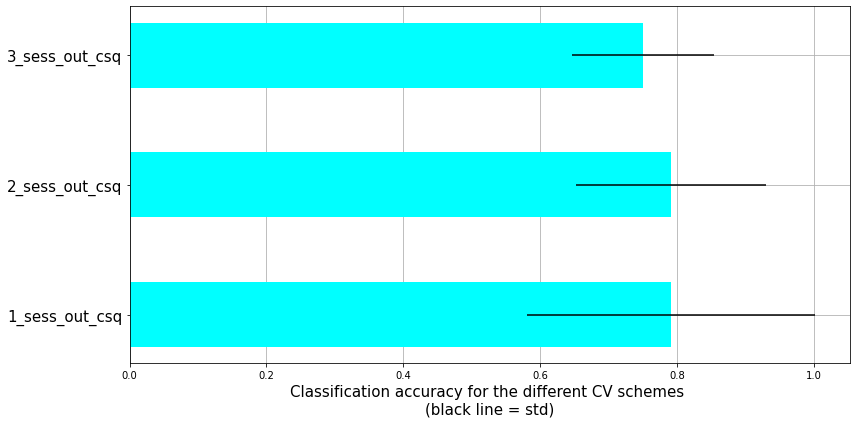

In [15]:
import matplotlib.pyplot as plt

mean_scores = [cvscheme_M1[scheme][0] for scheme in cv_schemes_csq]
scores_std = [cvscheme_M1[scheme][1] for scheme in cv_schemes_csq]

plt.figure(figsize=(12, 6))
positions = np.arange(len(cv_schemes_csq)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std,color='cyan',tick_label=mean_scores)
yticks = [k.replace(' ', '\n') for k in cv_schemes_csq]
plt.yticks(positions, yticks, fontsize=15)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.xlabel('Classification accuracy for the different CV schemes \n(black line = std)', fontsize=15)
plt.tight_layout()

#PART 2 - METHOD 2.2 : LeaveOneGroupOut()

Instead of defining the schemes by hand for the sessions that will be out, we just use the LeaveOneGroupOut() sklearn cross-validator implementation. The sessions will be grouped directly in the "run_decoder" function we previously defined : the session_label variable will be divided according to the n_group_out value (1,2, or 3), wich will enable grouping sessions per 1,2 or 3.

In [16]:
#question 2 - Method 2.2

#### Define cv object and parameters ####
cv = LeaveOneGroupOut() #split the data in train and test sets (data splitted according to a third-party)

cv_scores = list()
std_scores = list()
scores = {}


#### Calculate average score and variability across folds (std) for the different schemes defined in "leave_n_out" variable ####
for n in leave_n_out:
  print('\n* CV scheme : Leave-{}-session-out'.format(n))

  decoder,avg_score = run_decoder(
      cv=cv,
      group_by=session_label, #define the group as session
      n_group_out=n, #merge sessions by group of 1, 2 or 3 (defined in leave_n_out)
      print_folds=True)
  
  cv_scores.append(np.mean(avg_score))
  std_scores.append(np.std(avg_score))

cvscheme_M2 = dict(zip(cv_schemes_csq,zip(cv_scores,std_scores)))

dict_schemes['Question2_Method2']=cvscheme_M2

dict(zip(cvscheme_M2,zip(cv_scores,std_scores)))



* CV scheme : Leave-1-session-out
 Defined Decoder object with folowing parameters : Decoder(cv=LeaveOneGroupOut(), mask='/root/nilearn_data/haxby2001/mask.nii.gz',
        scoring='accuracy', screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : LeaveOneGroupOut()
* CV scheme : Leave-1-session-out
* n folds = 12

 - CV Fold 0 : Prediction accuracy = 0.94
 - Group out (test set) : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 (test size =18 --> 1 sessions out)
 - CV Fold 1 : Prediction accuracy = 1.00
 - Group out (test set) : [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
 (test size =18 --> 1 sessions out)
 - CV Fold 2 : Prediction accuracy = 1.00
 - Group out (test set) : [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
 (test size =18 --> 1 sessions out)
 - CV Fold 3 : Prediction accuracy = 0.67
 - Group out (test set) : [54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
 (test size =18 --> 1 sessions out)


{'1_sess_out_csq': (0.7916666666666666, 0.2104827392901723),
 '2_sess_out_csq': (0.7916666666666666, 0.13865721418399943),
 '3_sess_out_csq': (0.7499999999999999, 0.1035216656249903)}

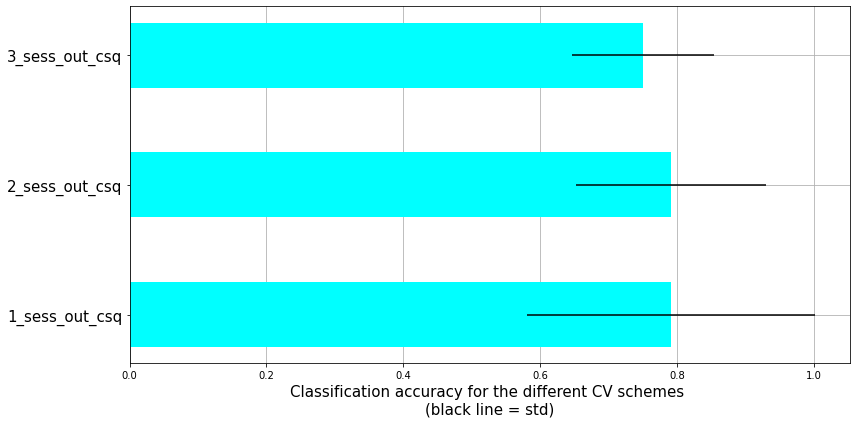

In [17]:
mean_scores = [cvscheme_M2[scheme][0] for scheme in cv_schemes_csq]
scores_std = [cvscheme_M2[scheme][1] for scheme in cv_schemes_csq]

plt.figure(figsize=(12, 6))
positions = np.arange(len(cv_schemes_csq)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std,color='cyan')
yticks = [k.replace(' ', '\n') for k in cv_schemes_csq]

plt.yticks(positions, yticks, fontsize=15)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.xlabel('Classification accuracy for the different CV schemes \n(black line = std)', fontsize=15)
plt.tight_layout()

In [18]:
#Print the results for the 2 methods implemented above (Method 1 & Method 2 - PART 2)
dict_schemes

{'Question2_Method1': {'1_sess_out_csq': (0.7916666666666666,
   0.2104827392901723),
  '2_sess_out_csq': (0.7916666666666666, 0.13865721418399943),
  '3_sess_out_csq': (0.7499999999999999, 0.1035216656249903)},
 'Question2_Method2': {'1_sess_out_csq': (0.7916666666666666,
   0.2104827392901723),
  '2_sess_out_csq': (0.7916666666666666, 0.13865721418399943),
  '3_sess_out_csq': (0.7499999999999999, 0.1035216656249903)}}

We note that we have a limited amoount of data, and the two methods presented above (redefining the group variable, by merging two consecutive sessions together), reduce even more the data we have available. 
However, it is very important to have large test sets to obtain a good power for the prediction error for each CV fold. Indeed, we have seen that the the prediction error across splits decreases when we increase the size of the test set :  
- Leave-1-Out : 'session_label ': (0.7824074074074074, 0.20344048650666513) \\
- Leave-2-Out : 'session_label_consq2': (0.7407407407407408, 0.12283795519834816) \\
- Leave-3-Out : 'session_label_consq3': (0.7037037037037036, 0.1134023029066286)}

Besides, we also notice a decrease in the variance of the accuracy when we increase the test size. 
It is therefore important to not rely solely on the accuracy score, but only to have a look at the estimated accuracy, but to also have a look at its variance, in order to define a propoer and well-balanced CV scheme. 
Indeed, we note that in these two leave-n-out schemes using LeaveOneOut() method, only one class (composed of one, two, or three merged sessions) is represented in the test set, and the reciproque can be made regarding the train set, that is therefore much reduced : resulting in an imbalanced dataset. 

Given these concerns, we test here a third method, that will allow to leave two- or three- consequtive samples out (increase test size), while increasing the number of folds 

We see that Method 2 amounts to doing exactly what we did with Method 1.
Instead of redefining the group (sessions) directly from the dataset, the dataset is directly split by the corresponding number defined in leave_n_out (1, 2 or 3). 
We see that this method (grouping and leaving n sessions out) is not optimal, as we loose a lot of training data, the number of folds decreasing (12 --> 6 --> 4).
One solution to leave 2 or 3 consecutive out without any loss of data would be to make "overlapping" groups, eg leaving consecutively sessions [1,2], then [2,3], then [3,4], etc.... (instead of [1,2],[3,4]).
To implement this, we will implement a third method (Method 2.3), using a Leave P Group(s) Out cross-validator.

#PART 2 BONUS - METHOD 3 : LeavePGroupOuts()

In this method, 2 groups will be consequtively be taken out to do the CV. But we see that each combinaison of groups will be taken out.

In [19]:
#question 2 - Method 2.3

from sklearn.model_selection import LeavePGroupsOut


#### Define cv object and parameters ####
cv_scores = list()
std_scores = list()
scores = {}

#### Calculate average score and variability across folds (std) for the different schemes defined in "leave_n_out" variable ####
for p in leave_n_out :
  cv = LeavePGroupsOut(n_groups=p) #split the data in train and test sets 
  print(cv.split)
  decoder,avg_score = run_decoder(cv,
                                  group_by=session_label,  #define the group as sessions
                                  n_group_out=1,
                                  print_folds=False)

  print(' Defined Decoder object : \n {}'.format(decoder))


  cv_scores.append(np.mean(avg_score))
  std_scores.append(np.std(avg_score))

cvscheme_M3 = dict(zip(cv_schemes_csq,zip(cv_scores,std_scores)))

dict_schemes['Question2_Method3']=cvscheme_M3 #store the results of this method for comparing later all the methods and scores

dict(zip(cv_schemes_csq,zip(cv_scores,std_scores)))

<bound method LeavePGroupsOut.split of LeavePGroupsOut(n_groups=1)>
 Defined Decoder object with folowing parameters : Decoder(cv=LeavePGroupsOut(n_groups=1),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : LeavePGroupsOut(n_groups=1)
* CV scheme : Leave-1-session-out
* n folds = 12

______________________________________________________________________
Average prediction accuracy score : 0.79 +- 0.21 (std)
Run time : 65.66 s
______________________________________________________________________
 Defined Decoder object : 
 Decoder(cv=LeavePGroupsOut(n_groups=1), estimator=LinearSVC(max_iter=10000.0),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz',
        memory=Memory(location=None), scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)
<bound method LeavePGroupsOut.split of LeavePGroupsOut(n_groups=2)>
 Defined Decoder object w

{'1_sess_out_csq': (0.7916666666666666, 0.2104827392901723),
 '2_sess_out_csq': (0.7706228956228957, 0.15611301373055791),
 '3_sess_out_csq': (0.7332491582491584, 0.13331109203844826)}

Here, the problem is now that we have too many folds : the LeavePGroupOut() cross validator leave several sessions out but the same group will appear in all different combinations.  
This cross-validation method is very costly, especially when we increase the number of group out.

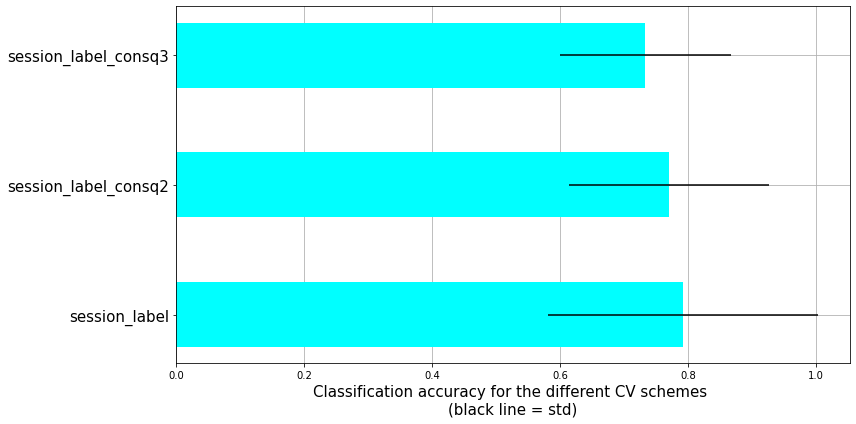

In [20]:
mean_scores = [cvscheme_M3[scheme][0] for scheme in cv_schemes_csq]
scores_std = [cvscheme_M3[scheme][1] for scheme in cv_schemes_csq]

plt.figure(figsize=(12, 6))
positions = np.arange(len(cv_schemes_csq)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std,color='cyan')
yticks = [k.replace(' ', '\n') for k in cv_schemes]
plt.yticks(positions, yticks, fontsize=15)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.xlabel('Classification accuracy for the different CV schemes \n(black line = std)', fontsize=15)
plt.tight_layout()

In [21]:
dict_schemes

{'Question2_Method1': {'1_sess_out_csq': (0.7916666666666666,
   0.2104827392901723),
  '2_sess_out_csq': (0.7916666666666666, 0.13865721418399943),
  '3_sess_out_csq': (0.7499999999999999, 0.1035216656249903)},
 'Question2_Method2': {'1_sess_out_csq': (0.7916666666666666,
   0.2104827392901723),
  '2_sess_out_csq': (0.7916666666666666, 0.13865721418399943),
  '3_sess_out_csq': (0.7499999999999999, 0.1035216656249903)},
 'Question2_Method3': {'1_sess_out_csq': (0.7916666666666666,
   0.2104827392901723),
  '2_sess_out_csq': (0.7706228956228957, 0.15611301373055791),
  '3_sess_out_csq': (0.7332491582491584, 0.13331109203844826)}}

#PART 3 
#Question 3: 
Change the cross validation scheme by shuffling the ‘session’ variable (i.e. randomizing it). \\
- What is the impact on the average score and on the variability ? 
- How can one interpret this ?



In [22]:
shuffle_session_label = session_label.sample(frac = 1) #shuffle the labels by hand, outside the CV instance

# PART 3 - METHOD 1 : LeaveOneOut & Redefine Shuffle session index by hand

As we did in the Method 2.1, here we first test to shuffle the labels by hand, outside the CV instance. This way allow us to keep exacly the same CV parameters used before, while just shuffling the session variable (ie randomizing it)

In [23]:
#question 3 - Method 3.1
cv_schemes = cv_schemes_nocsq # shift to "non consequtive out" scheme
cv = LeaveOneGroupOut() 
group_by = shuffle_session_label
n_group_out = 1 #allows to modify CV scheme : number of group outs

cv_scores = list()
std_scores = list()
scores = {}

decoder,avg_score = run_decoder(cv,group_by,n_group_out,print_folds=True)
cv_scores.append(np.mean(avg_score))
std_scores.append(np.std(avg_score))

cvscheme_Q3M1 = dict(zip(cv_schemes,zip(cv_scores,std_scores)))

dict_schemes['Question3_Method1']=cvscheme_Q3M1 #store the results of this method for comparing later all the methods and scores

dict(zip(cv_schemes,zip(cv_scores,std_scores)))

 Defined Decoder object with folowing parameters : Decoder(cv=LeaveOneGroupOut(), mask='/root/nilearn_data/haxby2001/mask.nii.gz',
        scoring='accuracy', screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : LeaveOneGroupOut()
* CV scheme : Leave-1-session-out
* n folds = 12

 - CV Fold 0 : Prediction accuracy = 1.00
 - Group out (test set) : [ 31  40  44  58  60  65  68  83  93  95  96 142 148 153 162 174 178 203]
 (test size =18 --> 1 sessions out)
 - CV Fold 1 : Prediction accuracy = 1.00
 - Group out (test set) : [  1   5  41  51  66 100 101 128 134 139 140 144 159 163 166 185 193 201]
 (test size =18 --> 1 sessions out)
 - CV Fold 2 : Prediction accuracy = 0.94
 - Group out (test set) : [  6   8  17  20  29  43  54  56  69  78 109 143 161 181 188 204 206 209]
 (test size =18 --> 1 sessions out)
 - CV Fold 3 : Prediction accuracy = 1.00
 - Group out (test set) : [  9  26  27  49  70  73  79  97 126 127 133 147 165 175 180 207 210 212]

{'1_sess_out': (0.9907407407407408, 0.020704333124998062)}

The prediction power seems weirdly elevated. This can be interpreted as the fact that as all sessions are shuffled, there are no really "new" data for the test set. In other words, the classifier will be trained with data from all sessions, and tested with data from all sessions also. We will test different CV scheme with shuffled session variable to observe the impact on the accuracy score and its variation across folds.
But in this case, the LeaveOneOut() do not seem to be a good method.

# PART 3 - METHOD 2 : KFold

We test the same with the shuffled data "shuffle_session_label" that we defined by hand, but now with a different cross validator : KFold, to observe any modification in the scores or variance

In [24]:
# Method 3.2

from sklearn import model_selection
from sklearn.model_selection import KFold

#NB : stratification making sure each fold is an appropriate representative of the original data (class distribution, mean, variance, etc)
n_splits = len(np.unique(behavioral['chunks'][condition_mask]))
kf = KFold(n_splits=12,random_state=1,shuffle=True)
n_group_out = 1 #allows to modify CV scheme : number of group outs

decoder,avg_score = run_decoder(cv=kf,
                                group_by=session_label,
                                n_group_out=n_group_out,
                                print_folds=False)


cv_scores = list()
std_scores = list()
scores = {}
cv_scores.append(np.mean(avg_score))
std_scores.append(np.std(avg_score))

cvscheme_Q3M2 = dict(zip(cv_schemes,zip(cv_scores,std_scores)))

dict_schemes['Question3_Method2']=cvscheme_Q3M2 #store the results of this method for comparing later all the methods and scores

dict(zip(cv_schemes,zip(cv_scores,std_scores)))

 Defined Decoder object with folowing parameters : Decoder(cv=KFold(n_splits=12, random_state=1, shuffle=True),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : KFold(n_splits=12, random_state=1, shuffle=True)
* CV scheme : Leave-1-session-out
* n folds = 12

______________________________________________________________________
Average prediction accuracy score : 1.00 +- 0.02 (std)
Run time : 173.23 s
______________________________________________________________________


{'1_sess_out': (0.9953703703703703, 0.015354744399793525)}

# PART 3 - METHOD 3 : GroupShuffleSplit
To make sure the results are consistents with other CV iterators of sklearn, we also tested with Group Suffle Split.
The GroupShuffleSplit iterator behaves as a combination of ShuffleSplit and LeavePGroupsOut, and generates a sequence of randomized partitions in which a subset of groups are held out for each split. We show that we obtain the same results with such combination : 

In [25]:
#question 3 - Method 3.3

from sklearn.model_selection import GroupShuffleSplit

#NB : stratification making sure each fold is an appropriate representative of the original data (class distribution, mean, variance, etc)
n_splits = len(np.unique(behavioral['chunks'][condition_mask]))
group_by = shuffle_session_label
n_group_out = 1 #allows to modify CV scheme : number of group outs


gss = GroupShuffleSplit(random_state=1,n_splits=n_splits,test_size=18/len(conditions)) #we keep the same number of folds and test size to better compare with the previous schemes

decoder,avg_score = run_decoder(cv=gss,group_by=group_by,n_group_out=1,print_folds=True)

cv_scores = list()
std_scores = list()
scores = {}
cv_scores.append(np.mean(avg_score))
std_scores.append(np.std(avg_score))

cvscheme_Q3M3 = dict(zip(cv_schemes,zip(cv_scores,std_scores)))

dict_schemes['Question3_Method3']=cvscheme_Q3M3 #store the results of this method for comparing later all the methods and scores

dict(zip(cv_schemes,zip(cv_scores,std_scores)))


 Defined Decoder object with folowing parameters : Decoder(cv=GroupShuffleSplit(n_splits=12, random_state=1, test_size=0.08333333333333333,
         train_size=None),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : GroupShuffleSplit(n_splits=12, random_state=1, test_size=0.08333333333333333,
         train_size=None)
* CV scheme : Leave-1-session-out
* n folds = 12

 - CV Fold 0 : Prediction accuracy = 0.94
 - Group out (test set) : [  6   8  17  20  29  43  54  56  69  78 109 143 161 181 188 204 206 209]
 (test size =18 --> 1 sessions out)
 - CV Fold 1 : Prediction accuracy = 1.00
 - Group out (test set) : [  1   5  41  51  66 100 101 128 134 139 140 144 159 163 166 185 193 201]
 (test size =18 --> 1 sessions out)
 - CV Fold 2 : Prediction accuracy = 1.00
 - Group out (test set) : [ 18  35  48  55  64  76  77  90  91 102 106 114 115 120 122 164 184 214]

{'1_sess_out': (0.9814814814814815, 0.026189140043946214)}

Cross validation relies on independance between train/test sets. It is therefore important to take into account the autocorrelation of brain signals (here fMRI).
Here, we tested with three different schemes :
- one LeaveOneOut() with sessions labels randomized by hand. We tested this approach in order to use the same CV parameters as in Question 1 and 2, but just randomizing the groups. This enables us to better compare the two schemes.
- one KFolds with shuffle=True, as we do not take into account the group variable anymore. This way, the data (and therefore groups) are shuffled before being splitted into batches.
- one with GroupShuffle split that allow us to shuffle the groups


# Bonus (for sanitary check) : StratifiedGroupKFold with session_label
Finally, we use the StratifiedGroupKFold strategy, but keep the original session_label (non shuffled by hand). 
Here, we just shuffled the order for the sessions to be left one. But this refers to the previous schemes, when one session is left out. As we see, this is therefore not relevant here, as we get the same results as in the previous question (with leave-one-consequtive out).

In [26]:
# Method 3.2

from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit,GroupShuffleSplit,StratifiedKFold,LeavePOut
from sklearn.model_selection import StratifiedGroupKFold

#NB : stratification making sure each fold is an appropriate representative of the original data (class distribution, mean, variance, etc)
n_splits = len(np.unique(behavioral['chunks'][condition_mask]))

sgkf = StratifiedGroupKFold(n_splits=n_splits,random_state=2,shuffle=True)
n_group_out = 1 #allows to modify CV scheme : number of group outs

decoder,avg_score = run_decoder(cv=sgkf,
                                group_by=session_label,
                                n_group_out=n_group_out,
                                print_folds=False)




 Defined Decoder object with folowing parameters : Decoder(cv=StratifiedGroupKFold(n_splits=12, random_state=2, shuffle=True),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : StratifiedGroupKFold(n_splits=12, random_state=2, shuffle=True)
* CV scheme : Leave-1-session-out
* n folds = 12

______________________________________________________________________
Average prediction accuracy score : 0.79 +- 0.21 (std)
Run time : 186.33 s
______________________________________________________________________


#PART 4 
#Question 4: 
Back to the non-randomized session variable, do a ‘leave-two-session-out’ (non-consecutive) cross-validation. 
- Compare with ‘leave-two-consecutive-session-out’. 
- How can one interpret the difference in terms of mean and variability of the accuracy score ?

#PART 4 - METHOD 1 - GroupShuffleSplit

The GroupShuffleSplit iterator behaves as a combination of ShuffleSplit and LeavePGroupsOut, and generates a sequence of randomized partitions in which a subset of groups are held out for each split.

Note that we keep only 6 splits to better compare with the leave-2-consequtive sessions out

In [27]:
from sklearn.model_selection import GroupShuffleSplit
cv_schemes = ['2_sess_out_non_csq']

#NB : stratification making sure each fold is an appropriate representative of the original data (class distribution, mean, variance, etc)
n_splits = len(np.unique(behavioral['chunks'][condition_mask]))//2
group_by = session_label*2
n_group_out = 2 #allows to modify CV scheme : number of group outs


gss = GroupShuffleSplit(n_splits=n_splits,test_size=18/len(conditions)*2) #we keep the same number of folds and test size to better compare with the previous schemes

decoder,avg_score = run_decoder(cv=gss,
                                group_by=group_by,
                                n_group_out=n_group_out,
                                print_folds=True)

cv_scores = list()
std_scores = list()
scores = {}
cv_scores.append(np.mean(avg_score))
std_scores.append(np.std(avg_score))

cvscheme_Q4M1 = dict(zip(cv_schemes,zip(cv_scores,std_scores)))

dict_schemes['Question4_Method1']=cvscheme_Q4M1 #store the results of this method for comparing later all the methods and scores

dict(zip(cv_schemes,zip(cv_scores,std_scores)))


 Defined Decoder object with folowing parameters : Decoder(cv=GroupShuffleSplit(n_splits=6, random_state=None,
         test_size=0.16666666666666666, train_size=None),
        mask='/root/nilearn_data/haxby2001/mask.nii.gz', scoring='accuracy',
        screening_percentile=5, smoothing_fwhm=4)


* Classification task : cat vs face
* CV generator : GroupShuffleSplit(n_splits=6, random_state=None,
         test_size=0.16666666666666666, train_size=None)
* CV scheme : Leave-2-session-out
* n folds = 6

 - CV Fold 0 : Prediction accuracy = 0.78
 - Group out (test set) : [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215]
 (test size =36 --> 2 sessions out)
 - CV Fold 1 : Prediction accuracy = 0.67
 - Group out (test set) : [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197]
 (test size =36 --> 2 sessio

{'2_sess_out_non_csq': (0.8796296296296298, 0.12491423669659299)}

In [28]:
question4 = ['Question2_Method1','Question4_Method1']
q4 = list()
for _,meth in enumerate(dict_schemes,1):
  if meth in question4:
    df_schemes = pd.DataFrame.from_dict(dict_schemes[meth], orient='index', columns=['mean', 'std'])
    df_schemes = df_schemes.rename_axis(meth)
    q4.append(df_schemes)
q4_compare = pd.concat(q4,keys=question4)

In [29]:
q4_compare

mean       std
Question2_Method1 1_sess_out_csq      0.791667  0.210483
                  2_sess_out_csq      0.791667  0.138657
                  3_sess_out_csq      0.750000  0.103522
Question4_Method1 2_sess_out_non_csq  0.879630  0.124914

Here, we see that the mean and variability of the accuracy score are higher and lower respectively, when the sessions are not consequtives. However, this should probably mean that it is easier to generalise for the classifier, as it is trained with data that are less auto-correlation with respect to their group sessions they belong to. 
However, the fMRI data is acquired by sessions, and the noise is autocorrelated in a given session. It is therefore better to predict across sessions when doing cross-validation, and avoid mixing sessions together : it is better to keep the scheme that is the most relevant regarding the experimental scheme. 

#CONCLUSION

In [30]:
d = list()
for _,meth in enumerate(dict_schemes,1):
  dict_method = dict_schemes[meth]
  df_schemes = pd.DataFrame.from_dict(dict_method, orient='index', columns=['mean', 'std'])
  df_schemes = df_schemes.rename_axis(meth)
  d.append(df_schemes)

df_methods = pd.concat(d,keys=list(dict_schemes.keys()))

In [31]:
df_methods

mean       std
Question2_Method1 1_sess_out_csq      0.791667  0.210483
                  2_sess_out_csq      0.791667  0.138657
                  3_sess_out_csq      0.750000  0.103522
Question2_Method2 1_sess_out_csq      0.791667  0.210483
                  2_sess_out_csq      0.791667  0.138657
                  3_sess_out_csq      0.750000  0.103522
Question2_Method3 1_sess_out_csq      0.791667  0.210483
                  2_sess_out_csq      0.770623  0.156113
                  3_sess_out_csq      0.733249  0.133311
Question3_Method1 1_sess_out          0.990741  0.020704
Question3_Method2 1_sess_out          0.995370  0.015355
Question3_Method3 1_sess_out          0.981481  0.026189
Question4_Method1 2_sess_out_non_csq  0.879630  0.124914

The goal of this TP is to investigate the effects of cross-validation (CV) schemes to decode visual stimuli categories ('cat' vs 'face') in a single subject (subject 2) of the Haxby dataset. A brief description of the dataset, and the images are displayed in the PART 0 of this TP.

We used a 'Decoder' model to predict external target variable (categorical object labels) given fMRI images.
As the decoder model is trained with labelled data (fMRI images associated with their categorical label from experimental condition), we need to evaluate how well it will be able to generalize when presented to new data, when measuring its predictive power of the model.
Indeed, we have seen in the first part of this TP that the accuracy score was 1 when we used labelled data to estimate the model's predictive power. 
To properly measure the predictive power of the model, we used a cross-validation (CV) approach : we split the data into train and test sets, that are respectively seen and unseen by the model. The test set is therefore used to compute the prediction error of the model, when classifying unseen data. 
In this TP, we used different CV schemes, and observed their consequences on accuracy and variance. We will note the important points that we observed : 

1. It seems preferable that CV should be performed on full chunks of correlated data. Here, this means that it is important to perform CV on consecutive sessions (correlated in time).
2. If the model can generalize across folds (eg sessions), it means that it will be useful to capture invariant information, that are present across all different folds.
3. "Leave-One-Sample-out" strategy seems a good strategy, as it seems to be the more in line with the experimental design, and therefore seems to be the best option given the high autocorrelation across samples. What is more, samples in the same session will naturally be the most correlated, and this correlation should naturally decreases with samples that are more distinct on time. 
4. Following the same idea, consecutive samples (folds) will be more correlated than non consequtive ones. This fact needs to be taken into account when defining the CV scheme, as this will have an influence of the predictive power, variance, as well as interpretation. 
2. Using repeated random splits seems to be preferred to leave-one-out.


As a final note, we have seen, through this TP that many considerations need to be taken into account when partinnioning the data for cross validations. In particular, it is very important to take into account the experimental design of the task, so that the cross validation scheme is consistent with the auto-correlative character of brain data. 
Given the difficulty of assessing a cross-validator, and finding the most appropriate one, we choose here to :   
- 1) print the behaviour of the different CV schemes, to control, assess and visualise the folds that are used 
- 2) use and show different cross validator for each question. This was motivated by the need to understand convergences and divergences of different CV schemes. 